# 0. Import library

In [92]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.options.display.float_format = "{:,.2f}".format

import warnings;
warnings.filterwarnings('ignore')

In [93]:
# nlp tools
import string
import nltk
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.corpus import stopwords
import re

from wordcloud import WordCloud

In [94]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Import data and sampling

In [95]:
df = pd.read_csv('Scraped data\scraped_data_559k.csv')

In [96]:
df.head()

,recommendationid,review,timestamp_created,voted_up
0,132354840,"Loe, love, LOVE this game.\n\nI purchased it w...",1675747403,True
1,132354525,shouldve been more,1675746707,False
2,132354176,It's fun,1675745970,True
3,132353890,full gen z game.,1675745336,False
4,132353500,it good that is all,1675744599,True


In [97]:
df['voted_up'].value_counts(), df['voted_up'].value_counts(normalize = True)

(True     385474
 False    173649
 Name: voted_up, dtype: int64,
 True    0.69
 False   0.31
 Name: voted_up, dtype: float64)

**Create stratified sample for testing**

We want to test our code on a small subset of the data first, and want to make sure the data has a similar label ratio of the full data.

In [98]:
df_sample = df.groupby('voted_up', group_keys=False).apply(lambda x: x.sample(frac=0.025, random_state=2077))
df_sample.reset_index(inplace=True)

In [99]:
df_sample['voted_up'].value_counts(), df_sample['voted_up'].value_counts(normalize = True)

(True     9637
 False    4341
 Name: voted_up, dtype: int64,
 True    0.69
 False   0.31
 Name: voted_up, dtype: float64)

In [100]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13978 entries, 0 to 13977
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              13978 non-null  int64 
 1   recommendationid   13978 non-null  int64 
 2   review             13933 non-null  object
 3   timestamp_created  13978 non-null  int64 
 4   voted_up           13978 non-null  bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 450.6+ KB


In [101]:
df_sample.describe()

,index,recommendationid,timestamp_created
count,"13,978.00","13,978.00","13,978.00"
mean,"280,613.31","105,525,291.05","1,639,833,271.75"
std,"161,384.02","19,274,721.85","26,611,257.13"
min,18.00,"67,290,896.00","1,586,866,697.00"
25%,"140,925.00","83,015,006.75","1,608,786,069.25"
50%,"280,851.00","106,055,763.50","1,639,853,808.00"
75%,"421,885.00","125,110,747.00","1,667,838,092.25"
max,"559,109.00","132,349,858.00","1,675,737,940.00"


# 2. Data Cleaning

In [102]:
df_sample.head()

,index,recommendationid,review,timestamp_created,voted_up
0,341972,130605748,Sweaty try hards that dont make the game worth...,1673399553,False
1,125277,83071676,"I have a 3070, tried running the game. Kept cr...",1608848571,False
2,433542,125403574,Horrible maps. Horrible feel of the game. No m...,1668336276,False
3,546233,109194579,it feels good to play with the latest teams wi...,1643651423,False
4,467032,124624026,trash game,1667087914,False


### 2.1 Remove nulls and duplicates

**Drop nulls**

In [103]:
df_sample['review'].isna().value_counts()

False    13933
True        45
Name: review, dtype: int64

In [104]:
df_sample.dropna(subset='review', inplace=True)

In [105]:
df_sample['review'].isna().value_counts()

False    13933
Name: review, dtype: int64

**Drop duplicates**

In [106]:
df_sample['review'].duplicated().value_counts()

False    12656
True      1277
Name: review, dtype: int64

In [107]:
df_sample[df_sample['review'].duplicated()]

,index,recommendationid,review,timestamp_created,voted_up
317,309556,103323080,garbage,1637662752,False
357,522069,67292237,nope,1586867999,False
403,466266,124632768,nope,1667101151,False
459,513130,69264181,.,1589662324,False
530,261866,117217800,bad,1655612702,False
...,...,...,...,...,...
13939,349457,129543043,good,1672257044,True
13946,374382,127782416,fun game,1670007370,True
13956,334561,131860306,good,1675071320,True
13957,458988,124752482,gg,1667271032,True


These duplicates reviews are from very short reviews. It's better to drop them.

In [108]:
df_sample.drop_duplicates(subset='review', keep='first', inplace=True)

In [109]:
df_sample['review'].duplicated().value_counts()

False    12656
Name: review, dtype: int64

### 2.2 Pipeline to remove stopwords, punctuation and formatting

**View sample data**

In [110]:
' '.join(df_sample['review'][50:150])

'So at first i have to say that the game is fun, but overall lack of maps, weapons, many features and fact that there is no singleplayer becouse thay said that they want to focus on multiplayer what was/is total BS is so dissapointing that i can\'t leave positive review.On top of that now is at sale and it is a little unfair that this game was 60$ andmonth after thet lower the price. sad Constant crashes, overpowered one shot sniper rifles.\n\nunfair player spawns on most hardpoint matches.\n if i cant do something as simple as progress the main story because i am not able to jump through a window, well... that says it all\n This game is really fun, but there are just way too many bugs, and the menus are all Janky. The battlepass doesn\'t actually give you the tokens until you reload the game. \n\nI\'ve been playing the DMZ mode with some friends recently, and when you crash, you get kicked and lose your guns. Really wish they\'d fix or make a fix for all these crashes.\n\nDefinitely n

**Remove formatting**

Review on steam use bbcode formatting. [h1] [/h1] [b] etc... We will need to use regex to match the patterns and remove those.

In [111]:
# prepare a test case that have most the common issue
# formatting
# stopword/punctuation
# contraction
# special/non latin characters

test_sentence = "[h1]It's a great story stories[/h1].\nYou'll need needs a [h2]balling PC[/h2]. It'll you'd won't isn't :'( $$$$ ...... GREATEST. GAME. EVER!!!!!@!&#^%*@!#. [spoiler]Virility[/spoiler] It stands stand for anything[/i][/b] скайрим 看看cdpr干的破事儿 Theyll youd wont isnt"

In [112]:
# The regex pattern is \[.*?\]
# Basically it will match the text from the open square bracket \[ 
# with any number of letter in between .* 
# to the first close bracket it can find ?\] (non greedy way)

def remove_markdown(input_string):
    input_string = str(input_string)
    result = re.sub(r'\[.*?\]', '', input_string)
    return result

In [113]:
test_remove_markdown = remove_markdown(test_sentence)
test_remove_markdown

"It's a great story stories.\nYou'll need needs a balling PC. It'll you'd won't isn't :'( $$$$ ...... GREATEST. GAME. EVER!!!!!@!&#^%*@!#. Virility It stands stand for anything скайрим 看看cdpr干的破事儿 Theyll youd wont isnt"

**Remove punctuations**

In [114]:
def remove_puns(input_string):
    result = [letter for letter in input_string if letter not in string.punctuation]
    result = ''.join(result)
    result = ' '.join(result.split()) #replace multiple spaces with single space
    return result

In [115]:
test_remove_puns = remove_puns(test_remove_markdown)
test_remove_puns

'Its a great story stories Youll need needs a balling PC Itll youd wont isnt GREATEST GAME EVER Virility It stands stand for anything скайрим 看看cdpr干的破事儿 Theyll youd wont isnt'

**Remove stopwords**

In [116]:
# create a custom stopwords list that include missing ' like wont, theyll, ive, etc
stopwords_default = stopwords.words('english')
stopwords_custom = [''.join(stopword.split('\'')) for stopword in stopwords_default] + ['theyll', 'theyd','theyre', 'woulda','wouldve','ive','imma','itll', 'youll']
stopwords_merged = set(stopwords_default).union(set(stopwords_custom))

In [117]:
def remove_stopwords(input_string):
    input_words = input_string.split(' ')
    result = [word for word in input_words if word.lower() not in stopwords_merged] 
    result = ' '.join(result) 
    return result

In [118]:
test_remove_stopwords = remove_stopwords(test_remove_puns)
test_remove_stopwords

'great story stories need needs balling PC GREATEST GAME EVER Virility stands stand anything скайрим 看看cdpr干的破事儿'

**Remove non latin character**

In [119]:
from nltk.tokenize import RegexpTokenizer
def remove_non_latin(input_string):
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    return tokenizer.tokenize(input_string.lower())

In [120]:
test_remove_nonlatin = remove_non_latin(test_remove_stopwords)
test_remove_nonlatin

['great',
 'story',
 'stories',
 'need',
 'needs',
 'balling',
 'pc',
 'greatest',
 'game',
 'ever',
 'virility',
 'stands',
 'stand',
 'anything',
 'cdpr']

**Lemmatizing**

Reduce multiple forms of a word to its basic form.

In [121]:
def lemmatize(input_list):
    lemmatizer = WordNetLemmatizer()
    result = list(map(lemmatizer.lemmatize, input_list))
    return result

In [122]:
test_lemmatize = lemmatize(test_remove_nonlatin)
test_lemmatize

['great',
 'story',
 'story',
 'need',
 'need',
 'balling',
 'pc',
 'greatest',
 'game',
 'ever',
 'virility',
 'stand',
 'stand',
 'anything',
 'cdpr']

**Part of speech tagging**

In [123]:
def pos_tagging(input_list):
    tagged = nltk.pos_tag(input_list)
    return ['_'.join(word) for word in tagged]

In [124]:
test_pos = pos_tagging(test_lemmatize)
test_pos

['great_JJ',
 'story_NN',
 'story_NN',
 'need_VBP',
 'need_VBP',
 'balling_VBG',
 'pc_NN',
 'greatest_JJS',
 'game_NN',
 'ever_RB',
 'virility_NN',
 'stand_VBP',
 'stand_VBP',
 'anything_NN',
 'cdpr_NN']

**Make pipeline**

In [125]:
def review_cleaning(input_string):
    result = remove_markdown(input_string)
    result = remove_puns(result)
    result = remove_stopwords(result)
    result = remove_non_latin(result)
    result = lemmatize(result)
    result = ' '.join(result)

    return result

In [126]:
def review_cleaning_pos(input_string):
    result = remove_markdown(input_string)
    result = remove_puns(result)
    result = remove_stopwords(result)
    result = remove_non_latin(result)
    result = lemmatize(result)
    result = pos_tagging(result)
    result = ' '.join(result)
    return result

In [127]:
%%time
X = df_sample['review'].apply(review_cleaning)
y = df_sample.voted_up

CPU times: total: 1.39 s
Wall time: 1.71 s


In [128]:
%%time
X_pos = df_sample['review'].apply(review_cleaning_pos)
y = df_sample.voted_up

CPU times: total: 18.7 s
Wall time: 21.7 s


POS tagging took significantly longer time to do. In a draft test, the POS data actually performed worse on both train and test set. It looks like the corpus for game review is simple enough that POS would produce more noise. In the end I moved on with non tagged data.

## 3. EDA

### 3.1 WordCloud

Positive review

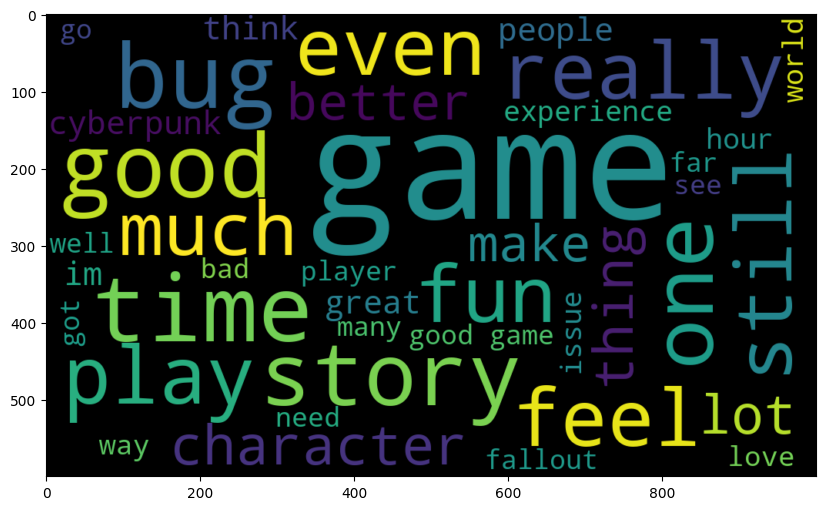

In [129]:
vote_up_cleaned = ' '.join(X[y])
plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'black', 
                      max_font_size = 200, 
                      max_words = 40, 
                      width = 1000, height = 600
                     ).generate(vote_up_cleaned)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

Negative review

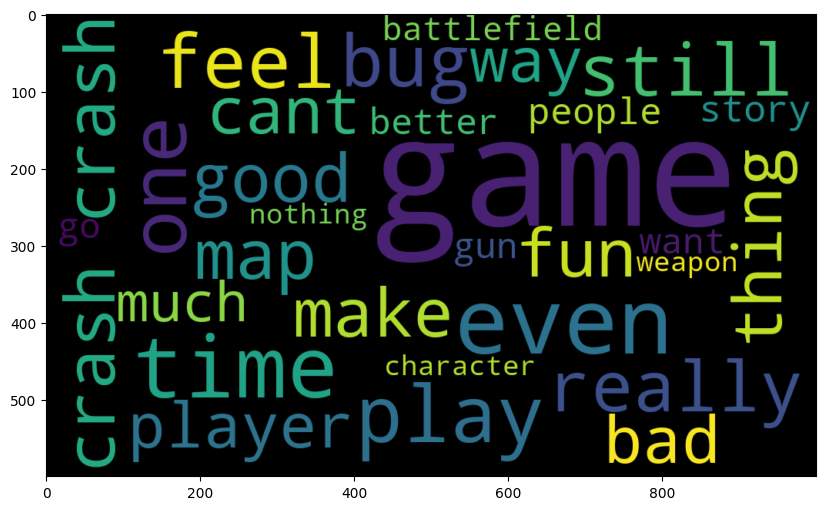

In [130]:
vote_down_cleaned = ' '.join(X[~y])

plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'black', 
                      max_font_size = 200, 
                      max_words = 30, 
                      width = 1000, height = 600
                     ).generate(vote_down_cleaned)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.show()

Some words like game, bug, play,... present on both the positive and negative reviews.

### 3.2 Frequency distribution

**Word counts:**

In [131]:
df_visualize = X.to_frame()

df_visualize['word_counts'] = df_visualize['review'].apply(lambda x: x.split(' ')).apply(len)
df_visualize['voted_up'] = df_sample['voted_up']

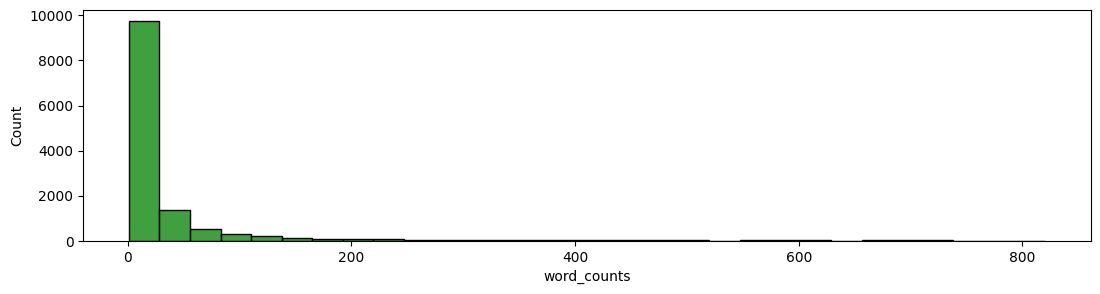

In [132]:
plt.figure(figsize=(13,3))
sns.histplot(data=df_visualize, x="word_counts",bins=30,color='green')

plt.show()

**Unique words:**

In [133]:
%%time
review_text_all = []
for review in df_visualize['review'].apply(lambda x: x.split(' ')):
    review_text_all +=review
f'Unique words: {len(set(review_text_all))}'

CPU times: total: 46.9 ms
Wall time: 62.8 ms


'Unique words: 20334'

**Positive / negative review text**

In [134]:
review_text_positive = []
for review in df_visualize['review'][df_visualize['voted_up']].apply(lambda x: x.split(' ')):
    review_text_positive +=review    
top_20_positive = pd.Series(review_text_positive).value_counts().head(20)
top_20_positive

game         10251
like          2239
good          2206
bug           2139
story         1803
fun           1681
play          1384
time          1344
great         1341
get           1340
really        1322
still         1191
one           1114
lot           1038
feel           955
would          936
world          901
even           889
character      874
im             857
dtype: int64

In [135]:
review_text_negative = []
for review in df_visualize['review'][~df_visualize['voted_up']].apply(lambda x: x.split(' ')):
    review_text_negative +=review
top_20_negative = pd.Series(review_text_negative).value_counts().head(20)
top_20_negative

game           7361
like           1489
even           1215
get            1178
crash          1116
play           1114
time           1068
bug             942
still           792
feel            768
one             758
good            743
really          681
cant            648
make            633
story           591
would           579
battlefield     573
map             558
bad             556
dtype: int64

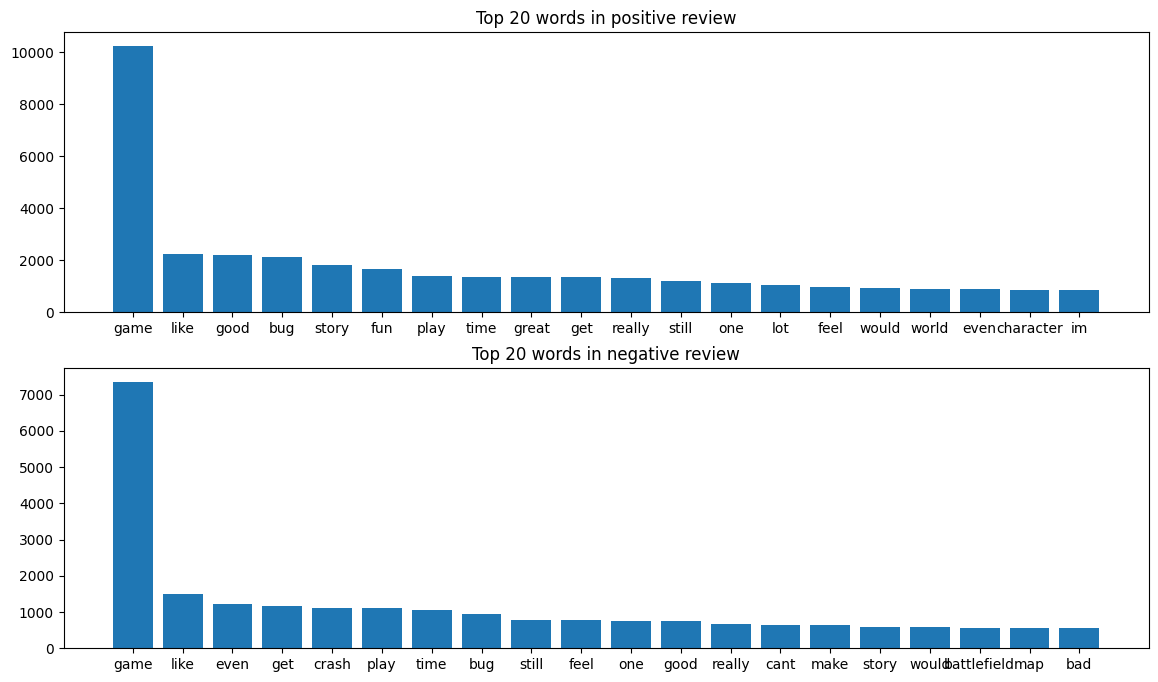

In [136]:
fig = plt.figure(figsize=(14,8))  
ax1 = fig.add_subplot(211)   
ax2 = fig.add_subplot(212) 

ax1.bar(top_20_positive.index, top_20_positive)
ax1.set_title('Top 20 words in positive review')

ax2.bar(top_20_negative.index, top_20_negative)
ax2.set_title('Top 20 words in negative review')
plt.show()

# 4. Preprocess

In [137]:
%%time
# features
X = df_sample['review'].apply(review_cleaning)

# target
y = df_sample.voted_up

X.head()

CPU times: total: 1.42 s
Wall time: 1.63 s


0    sweaty try hards make game worth time play 12 ...
1    3070 tried running game kept crashing every ne...
2    horrible map horrible feel game movement peopl...
3    feel good play latest team friend shit pretty ...
4                                           trash game
Name: review, dtype: object

### Bag of words

Bag of words simply count the occurence of each word presents in a review.

In [138]:
def bow_vectorizer(X_train, X_test, n_features):
    vectorizer = CountVectorizer(max_features = n_features, dtype = np.uint8)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())
    return X_train, X_test

### TF IDF

Unlike Bag of words approach, which only measures how often a particular term appears in a particular document, TFIDF also take into consideration how common/rare a term is across all documents in a corpus. 

In [139]:
def tfidf_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

### TF IDF with bigram

N-gram creates feature that are n adjacent words, which can has more information than one word along. Considering a word like just 'not', just 'bad' generally contribute to a negative sentiment in a BOW approach, a feature like 'not_bad' tends to be positive sentiment.

In [140]:
def tfidf2g_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

# 5. Baseline models

Before jumping into building the DL model, we build a few baseline models as a benchmark.

## Functions to store test result

In [141]:
columns = ['model name', 'data','time', 
           'train_down_Pre', 'train_down_Rec', 'train_down_F1',
           'train_up_Pre', 'train_up_Rec', 'train_up_F1',
           'train_acc',
           'test_down_Pre', 'test_down_Rec', 'test_down_F1',
           'test_up_Pre', 'test_up_Rec', 'test_up_F1',
           'test_acc']
           
df_metrics = pd.DataFrame(columns = columns)

In [142]:
def reset(df_metrics):
    return pd.DataFrame(columns = columns)

In [143]:
def classifier_performance(model_name, model, data, X_train, X_test, y_train, y_test):
    print(f'Training: {model_name} / {data}')
    start = time.time()
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    complete_time = time.time() - start
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)
    
    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, data, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    
    print(f'Finished in {complete_time:.2f}')
    print('='*50)
    # return df_metrics.loc[len(df_metrics.index)-1]

## Baseline models

In [144]:
NB_classifier = MultinomialNB()
LG_classifier = LogisticRegression(random_state = 14)
RF_classifier = RandomForestClassifier(random_state = 14)
XGB_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=14)

In [145]:
vectorizer_list = [bow_vectorizer, tfidf_vectorizer, tfidf2g_vectorizer]
n_features = [500,800, 1000, 1500, 2000]

models = [('NB_classifier', NB_classifier),
          ('LG_classifier',LG_classifier),
          ('RF_classifier',RF_classifier),
          ('XGB_classifier', XGB_classifier)
         ]


In [146]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=14)

# loop through the range of n_feature
for n_feature in n_features:
    # loop through the vectorizer
    for vectorizer in vectorizer_list:
        X_train_vectorized, X_test_vectorized = vectorizer(X_train, X_test, n_feature)
        # loop through the baseline models
        for model_name, model in models:
            classifier_performance(model_name, model, vectorizer.__name__+str(n_feature), 
                                   X_train_vectorized, X_test_vectorized, y_train, y_test)

Training: NB_classifier / bow_vectorizer500
Finished in 0.05
Training: LG_classifier / bow_vectorizer500
Finished in 0.35
Training: RF_classifier / bow_vectorizer500
Finished in 6.24
Training: XGB_classifier / bow_vectorizer500
[18:31:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Finished in 2.15
Training: NB_classifier / tfidf_vectorizer500
Finished in 0.03
Training: LG_classifier / tfidf_vectorizer500
Finished in 0.23
Training: RF_classifier / tfidf_vectorizer500
Finished in 7.80
Training: XGB_classifier / tfidf_vectorizer500
[18:31:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the ob

For result, we want to look the F1 score for 'test_down' (negative sentiment), as it's the class we are more interested in. Accuracy can be misleading in case of data imbalance like we have here.

In [147]:
summary = ['model name', 'data', 'time', 'train_acc','test_acc', 'train_up_F1', 'test_up_F1','train_down_F1', 'test_down_F1']
summary2 = ['model name', 'data', 'time', 'train_acc','test_acc', 'test_up_F1','test_down_F1']

df_metrics[summary2]

,model name,data,time,train_acc,test_acc,test_up_F1,test_down_F1
0,NB_classifier,bow_vectorizer500,0.05,0.82,0.81,0.86,0.68
1,LG_classifier,bow_vectorizer500,0.35,0.84,0.82,0.87,0.69
2,RF_classifier,bow_vectorizer500,6.24,0.96,0.79,0.85,0.66
3,XGB_classifier,bow_vectorizer500,2.15,0.88,0.82,0.87,0.69
4,NB_classifier,tfidf_vectorizer500,0.03,0.81,0.80,0.87,0.62
5,LG_classifier,tfidf_vectorizer500,0.23,0.84,0.83,0.88,0.71
6,RF_classifier,tfidf_vectorizer500,7.80,0.96,0.81,0.86,0.68
7,XGB_classifier,tfidf_vectorizer500,2.34,0.89,0.81,0.87,0.68
8,NB_classifier,tfidf2g_vectorizer500,0.03,0.81,0.81,0.87,0.64
9,LG_classifier,tfidf2g_vectorizer500,0.25,0.84,0.83,0.88,0.71


## Visualize metrics summary

In [148]:
df_metrics['preprocessed'] = df_metrics.data.str.split('_').apply(lambda x: x[0])
df_metrics['feature_size'] = df_metrics.data.str.split('_').apply(lambda x: x[-1][10:])

df_metrics_nonDL = df_metrics.copy()

### Accuracy on test set, by model (and by preprocess, and by feature size)

<Axes: xlabel='model name', ylabel='test_acc'>

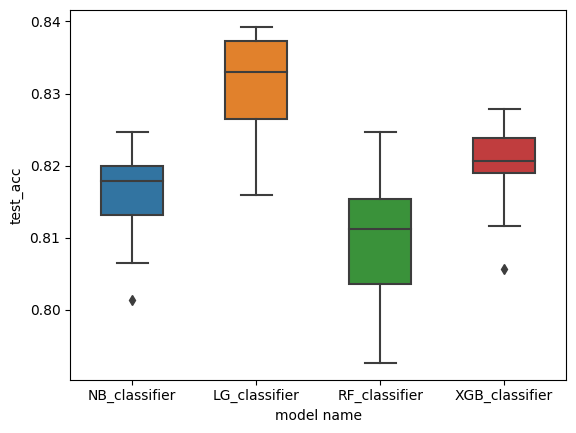

In [149]:
# test accuracy by model
sns.boxplot(data=df_metrics, x='model name', y='test_acc',width=0.5)

<Axes: xlabel='model name', ylabel='test_acc'>

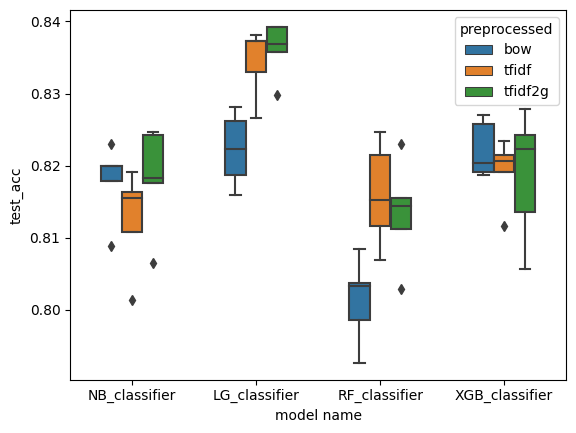

In [150]:
# test accuracy by model and preprocessed
sns.boxplot(data=df_metrics, x='model name', y='test_acc', hue = 'preprocessed', width=0.5)

<Axes: xlabel='model name', ylabel='test_acc'>

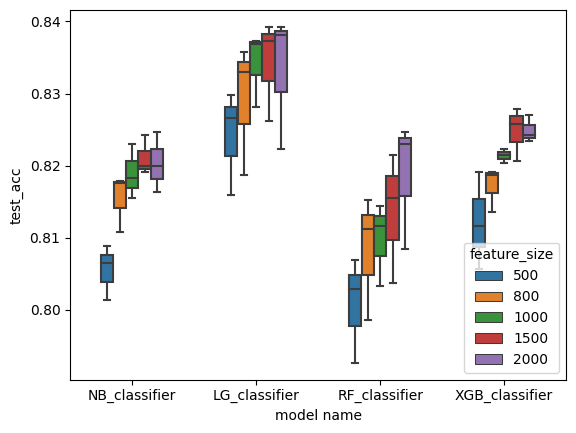

In [151]:
# test accuracy by model and feature size
sns.boxplot(data=df_metrics, x='model name', y='test_acc', hue = 'feature_size', width=0.5)

### F1 on test set, by model

<Axes: xlabel='model name', ylabel='test_down_F1'>

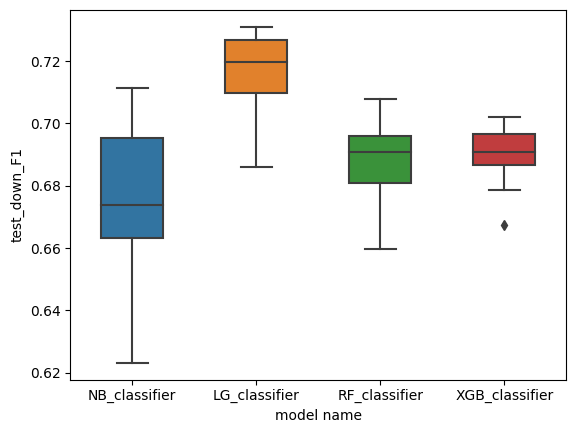

In [152]:
# test accuracy by model
sns.boxplot(data=df_metrics, x='model name', y='test_down_F1',width=0.5)

### F1 score for negative on test set, by model AND preprocess

<Axes: xlabel='model name', ylabel='test_down_F1'>

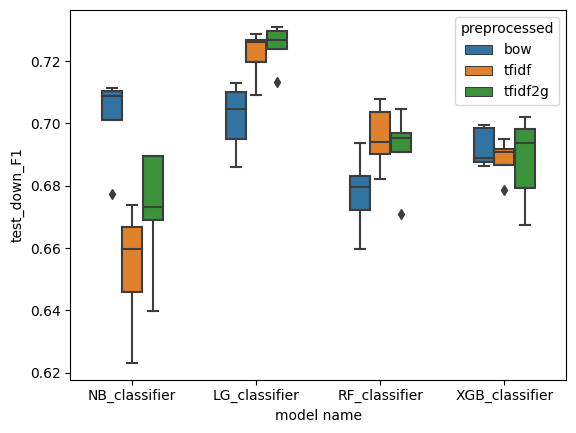

In [153]:
# test f1 (vote down) by model and preprocessed
sns.boxplot(data=df_metrics, x='model name', y='test_down_F1', hue='preprocessed', width=0.5)

### F1 score for negative on test set, by model AND feature size

<Axes: xlabel='model name', ylabel='test_down_F1'>

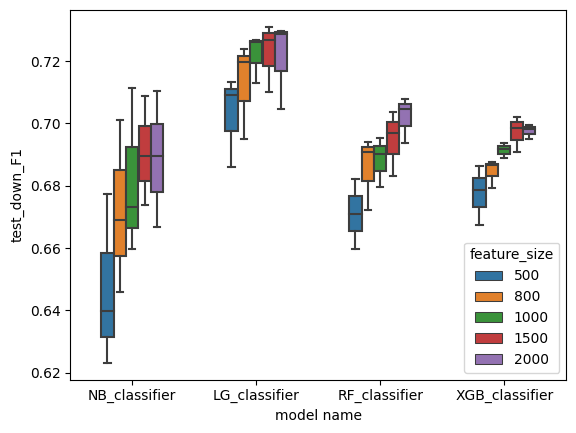

In [154]:
sns.boxplot(data=df_metrics, x='model name', y='test_down_F1', hue='feature_size', width=0.5)

### Conclusion

- Logistic regression have overall best performance in term of accuracy and F1 score.
- The baseline RF model and XGB model's performance could have improved if they were assigned class weights, due to balance imbalance.
- Having higher amount of features works for RF since it can handle high-dimensional data better , but not necessarily for logistic regression.
- In term of feature engineering techniques, TFIDF with bigram are somewhat better than the other 2.

# 6. Baseline DL models

In [155]:
# deep learning algo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Fixing the seed for random number generators
tf.random.set_seed(42)

# keras tuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

### Function to store metrics

In [156]:
def dl_performance(model_name, dlmodel, X_name, X_train, X_test, y_train, y_test, complete_time = 0, threshold = 0.5):
    
    #print('Training: ', model_name, '/', X_name)
    y_hat_train = np.where(dlmodel.predict(X_train) > threshold,1,0)
    y_hat_test = np.where(dlmodel.predict(X_test) > threshold,1,0)
    
    
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)

    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, X_name, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    print('Finished in',complete_time)
    print('='*50)
    return df_metrics.loc[len(df_metrics.index)-1]

In [157]:
def accuracy_vs_epochs(history, from_epoc=0):
    df_history = pd.DataFrame(history.history).iloc[from_epoc:]
    plt.figure(figsize = (4,2))
    plt.plot(df_history.iloc[:,1])
    plt.plot(df_history.iloc[:,3])
    plt.xlim(left=-1)
    plt.title(str(df_history.columns[1]) +  ' vs epochs')
    plt.ylabel(df_history.columns[1])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

### DL model

In [158]:
# function to create DL model
def make_DL_model(neuron_list, dropout_list, input_dim, metric='AUC'):
    
    model = Sequential()
    model.add(Dense(neuron_list[0], activation='relu',kernel_initializer='he_uniform',input_dim = input_dim))
    model.add(Dropout(dropout_list[0]))
    
    for neuron, dropout in zip(neuron_list[1:], dropout_list[1:]):
        model.add(Dense(neuron,activation='relu',kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
   
    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001), metrics=metric)
    return model

In [159]:
# early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

### Loops

In [160]:
df_metrics = reset(df_metrics)

Training:  DL_3layers / bow_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5859 - auc: 0.6935 - val_loss: 0.4317 - val_auc: 0.8793
Epoch 2/10
285/285 [==============================] - 0s 2ms/step - loss: 0.4546 - auc: 0.8473 - val_loss: 0.3996 - val_auc: 0.8876
Epoch 3/10
285/285 [==============================] - 0s 2ms/step - loss: 0.4067 - auc: 0.8779 - val_loss: 0.3961 - val_auc: 0.8889
Epoch 4/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3805 - auc: 0.8934 - val_loss: 0.4020 - val_auc: 0.8861
Epoch 5/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3561 - auc: 0.9077 - val_loss: 0.4033 - val_auc: 0.8839
Epoch 6/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3374 - auc: 0.9164 - val_loss: 0.4100 - val_auc: 0.8813
Epoch 7/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3110 - auc: 0.9287 - val_loss: 0.4350 - val_auc: 0.8769
Epoch 8/10
285/285 [==============

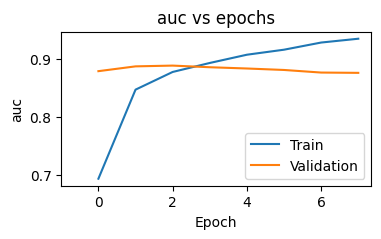

80/80 [==============================] - 0s 833us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.6093 - auc: 0.6635 - val_loss: 0.4474 - val_auc: 0.8710
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4797 - auc: 0.8308 - val_loss: 0.4018 - val_auc: 0.8862
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4231 - auc: 0.8671 - val_loss: 0.4034 - val_auc: 0.8844
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3934 - auc: 0.8873 - val_loss: 0.4057 - val_auc: 0.8865
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3685 - auc: 0.8997 - val_loss: 0.4067 - val_auc: 0.8862
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3385 - auc: 0.9154 - val_loss: 0.4172 - val_auc: 0.8784
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3140 - auc: 0.9288 - 

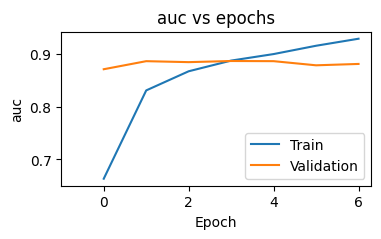

80/80 [==============================] - 0s 846us/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer500
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5284 - auc: 0.7645 - val_loss: 0.4083 - val_auc: 0.8788
Epoch 2/10
285/285 [==============================] - 0s 2ms/step - loss: 0.4125 - auc: 0.8714 - val_loss: 0.3995 - val_auc: 0.8810
Epoch 3/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3847 - auc: 0.8892 - val_loss: 0.4022 - val_auc: 0.8810
Epoch 4/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3612 - auc: 0.9036 - val_loss: 0.4071 - val_auc: 0.8767
Epoch 5/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3382 - auc: 0.9151 - val_loss: 0.4133 - val_auc: 0.8794
Epoch 6/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3162 - auc: 0.9249 - val_loss: 0.4198 - val_auc: 0.8728
Epoch 7/10
285/285 [==============================] - 0s 2ms/step - loss: 0.2969 - auc: 0.9338 

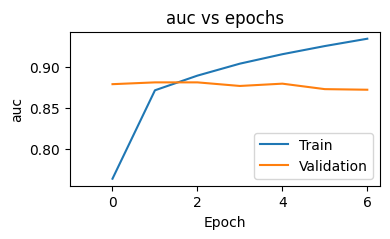

80/80 [==============================] - 0s 821us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5356 - auc: 0.7552 - val_loss: 0.3955 - val_auc: 0.8859
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4165 - auc: 0.8693 - val_loss: 0.3985 - val_auc: 0.8847
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3837 - auc: 0.8900 - val_loss: 0.3943 - val_auc: 0.8857
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3524 - auc: 0.9076 - val_loss: 0.4112 - val_auc: 0.8762
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3247 - auc: 0.9222 - val_loss: 0.4192 - val_auc: 0.8797
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2996 - auc: 0.9326 - val_loss: 0.4174 - val_auc: 0.8757
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2610 - auc: 0.9480 

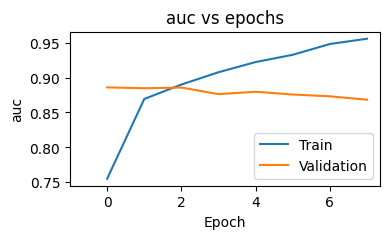

80/80 [==============================] - 0s 884us/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer500
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5344 - auc: 0.7591 - val_loss: 0.4158 - val_auc: 0.8766
Epoch 2/10
285/285 [==============================] - 0s 2ms/step - loss: 0.4144 - auc: 0.8711 - val_loss: 0.4042 - val_auc: 0.8793
Epoch 3/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3830 - auc: 0.8903 - val_loss: 0.4050 - val_auc: 0.8784
Epoch 4/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3624 - auc: 0.9025 - val_loss: 0.4085 - val_auc: 0.8754
Epoch 5/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3399 - auc: 0.9147 - val_loss: 0.4132 - val_auc: 0.8778
Epoch 6/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3174 - auc: 0.9256 - val_loss: 0.4209 - val_auc: 0.8748
Epoch 7/10
285/285 [==============================] - 0s 2ms/step - loss: 0.2975 - auc: 0.934

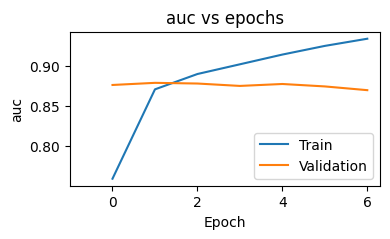

80/80 [==============================] - 0s 833us/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5430 - auc: 0.7460 - val_loss: 0.4154 - val_auc: 0.8770
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4177 - auc: 0.8671 - val_loss: 0.4067 - val_auc: 0.8776
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3852 - auc: 0.8898 - val_loss: 0.4009 - val_auc: 0.8817
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3621 - auc: 0.9034 - val_loss: 0.4051 - val_auc: 0.8772
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3345 - auc: 0.9174 - val_loss: 0.4182 - val_auc: 0.8743
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3041 - auc: 0.9316 - val_loss: 0.4371 - val_auc: 0.8663
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2769 - auc: 0.942

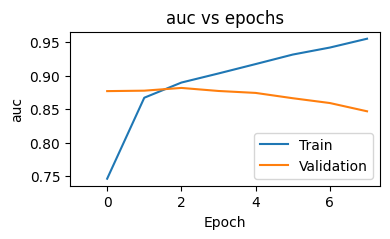

80/80 [==============================] - 0s 884us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5679 - auc: 0.7261 - val_loss: 0.4031 - val_auc: 0.8959
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4188 - auc: 0.8731 - val_loss: 0.3868 - val_auc: 0.8983
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3650 - auc: 0.9045 - val_loss: 0.3903 - val_auc: 0.8965
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3263 - auc: 0.9217 - val_loss: 0.4017 - val_auc: 0.8918
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2872 - auc: 0.9389 - val_loss: 0.4374 - val_auc: 0.8842
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2645 - auc: 0.9488 - val_loss: 0.4333 - val_auc: 0.8815
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2550 - auc: 0.9563 - 

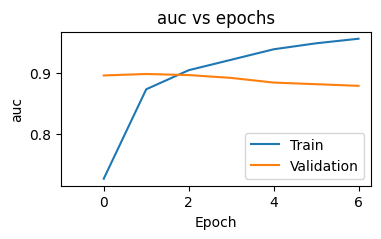

80/80 [==============================] - 0s 909us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5949 - auc: 0.6953 - val_loss: 0.4229 - val_auc: 0.8806
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4526 - auc: 0.8535 - val_loss: 0.3803 - val_auc: 0.9021
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3909 - auc: 0.8915 - val_loss: 0.3799 - val_auc: 0.9021
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3534 - auc: 0.9104 - val_loss: 0.3831 - val_auc: 0.8983
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3162 - auc: 0.9290 - val_loss: 0.3896 - val_auc: 0.9023
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2833 - auc: 0.9428 - val_loss: 0.4029 - val_auc: 0.8964
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2475 - auc: 0.9547 - 

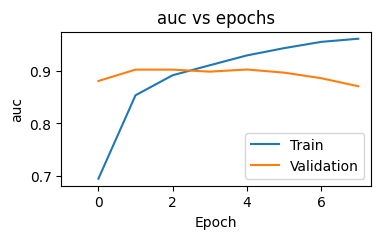

80/80 [==============================] - 0s 997us/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer800
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5129 - auc: 0.7888 - val_loss: 0.3895 - val_auc: 0.8946
Epoch 2/10
285/285 [==============================] - 0s 2ms/step - loss: 0.3819 - auc: 0.8928 - val_loss: 0.3784 - val_auc: 0.8952
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3476 - auc: 0.9110 - val_loss: 0.3832 - val_auc: 0.8916
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3151 - auc: 0.9280 - val_loss: 0.3961 - val_auc: 0.8875
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2912 - auc: 0.9373 - val_loss: 0.4147 - val_auc: 0.8852
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2632 - auc: 0.9477 - val_loss: 0.4259 - val_auc: 0.8842
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2383 - auc: 0.9570 

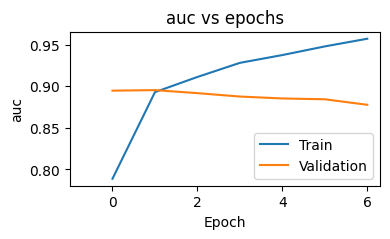

80/80 [==============================] - 0s 833us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5185 - auc: 0.7778 - val_loss: 0.3764 - val_auc: 0.8974
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3857 - auc: 0.8900 - val_loss: 0.3738 - val_auc: 0.8973
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3377 - auc: 0.9157 - val_loss: 0.3837 - val_auc: 0.8971
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3081 - auc: 0.9298 - val_loss: 0.3948 - val_auc: 0.8892
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2665 - auc: 0.9480 - val_loss: 0.4332 - val_auc: 0.8843
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2385 - auc: 0.9574 - val_loss: 0.4393 - val_auc: 0.8798
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2022 - auc: 0.9685 

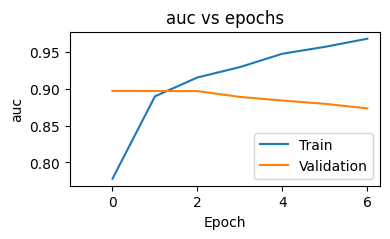

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer800
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5096 - auc: 0.7899 - val_loss: 0.3860 - val_auc: 0.8925
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3813 - auc: 0.8913 - val_loss: 0.3842 - val_auc: 0.8919
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3448 - auc: 0.9117 - val_loss: 0.3913 - val_auc: 0.8908
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3177 - auc: 0.9254 - val_loss: 0.4098 - val_auc: 0.8797
Epoch 5/10
285/285 [==============================] - 0s 2ms/step - loss: 0.2905 - auc: 0.9371 - val_loss: 0.4247 - val_auc: 0.8784
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2622 - auc: 0.9485 - val_loss: 0.4494 - val_auc: 0.8734
Epoch 7/10
285/285 [==============================] - 0s 2ms/step - loss: 0.2329 - auc: 0.9590 

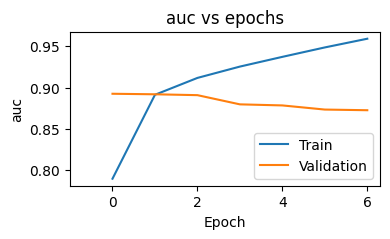

80/80 [==============================] - 0s 833us/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer800
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5218 - auc: 0.7732 - val_loss: 0.3886 - val_auc: 0.8921
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3907 - auc: 0.8870 - val_loss: 0.3851 - val_auc: 0.8917
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3467 - auc: 0.9123 - val_loss: 0.3945 - val_auc: 0.8866
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3132 - auc: 0.9282 - val_loss: 0.3982 - val_auc: 0.8843
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2728 - auc: 0.9450 - val_loss: 0.4338 - val_auc: 0.8794
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2323 - auc: 0.9598 - val_loss: 0.4507 - val_auc: 0.8739
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2087 - auc: 0.967

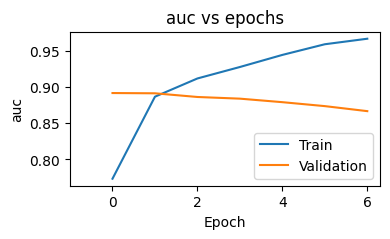

80/80 [==============================] - 0s 896us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer1000
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5437 - auc: 0.7608 - val_loss: 0.4005 - val_auc: 0.8930
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4080 - auc: 0.8816 - val_loss: 0.3649 - val_auc: 0.9098
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3468 - auc: 0.9121 - val_loss: 0.3614 - val_auc: 0.9089
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3132 - auc: 0.9294 - val_loss: 0.3915 - val_auc: 0.9006
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2849 - auc: 0.9402 - val_loss: 0.3897 - val_auc: 0.9047
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2598 - auc: 0.9520 - val_loss: 0.4196 - val_auc: 0.8943
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2273 - auc: 0.9617 -

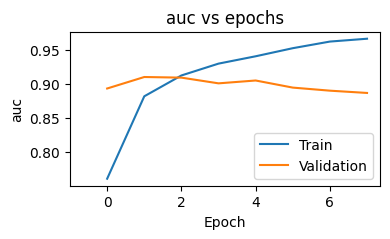

80/80 [==============================] - 0s 896us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5866 - auc: 0.6967 - val_loss: 0.4073 - val_auc: 0.8896
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.4332 - auc: 0.8655 - val_loss: 0.3697 - val_auc: 0.9043
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3672 - auc: 0.9041 - val_loss: 0.3680 - val_auc: 0.9081
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3235 - auc: 0.9229 - val_loss: 0.3795 - val_auc: 0.8985
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2880 - auc: 0.9408 - val_loss: 0.4149 - val_auc: 0.8969
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2633 - auc: 0.9497 - val_loss: 0.4130 - val_auc: 0.8915
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2272 - auc: 0.9609 -

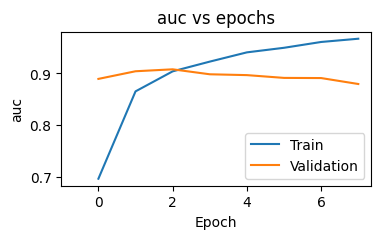

80/80 [==============================] - 0s 985us/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer1000
Epoch 1/10
285/285 [==============================] - 1s 3ms/step - loss: 0.5037 - auc: 0.7949 - val_loss: 0.3707 - val_auc: 0.9019
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3722 - auc: 0.8986 - val_loss: 0.3610 - val_auc: 0.9068
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3271 - auc: 0.9211 - val_loss: 0.3727 - val_auc: 0.9014
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2893 - auc: 0.9388 - val_loss: 0.3908 - val_auc: 0.8959
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2615 - auc: 0.9492 - val_loss: 0.4097 - val_auc: 0.8914
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2360 - auc: 0.9586 - val_loss: 0.4232 - val_auc: 0.8859
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2036 - auc: 0.9690

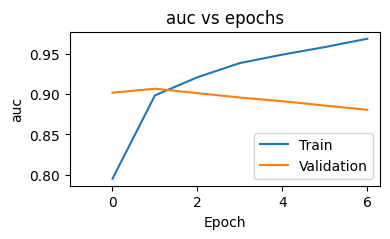

80/80 [==============================] - 0s 846us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5190 - auc: 0.7756 - val_loss: 0.3756 - val_auc: 0.9038
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3759 - auc: 0.8964 - val_loss: 0.3666 - val_auc: 0.9027
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3298 - auc: 0.9201 - val_loss: 0.3792 - val_auc: 0.8984
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2901 - auc: 0.9386 - val_loss: 0.3933 - val_auc: 0.8925
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2504 - auc: 0.9538 - val_loss: 0.4333 - val_auc: 0.8869
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2141 - auc: 0.9643 - val_loss: 0.4501 - val_auc: 0.8836
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1845 - auc: 0.9737

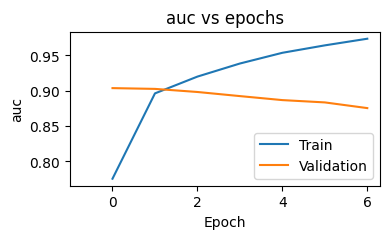

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5051 - auc: 0.7946 - val_loss: 0.3671 - val_auc: 0.9072
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3714 - auc: 0.8984 - val_loss: 0.3705 - val_auc: 0.9018
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3272 - auc: 0.9219 - val_loss: 0.3802 - val_auc: 0.8972
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2994 - auc: 0.9339 - val_loss: 0.3953 - val_auc: 0.8889
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2689 - auc: 0.9468 - val_loss: 0.4286 - val_auc: 0.8846
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2363 - auc: 0.9585 - val_loss: 0.4345 - val_auc: 0.8821


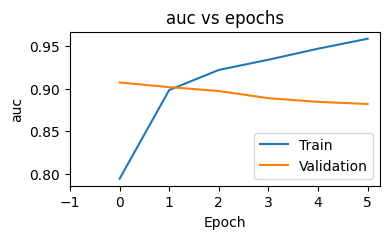

80/80 [==============================] - 0s 858us/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer1000
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5183 - auc: 0.7739 - val_loss: 0.3840 - val_auc: 0.8975
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3734 - auc: 0.8973 - val_loss: 0.3723 - val_auc: 0.9005
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3312 - auc: 0.9199 - val_loss: 0.3885 - val_auc: 0.8953
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2882 - auc: 0.9390 - val_loss: 0.4023 - val_auc: 0.8898
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2463 - auc: 0.9553 - val_loss: 0.4436 - val_auc: 0.8839
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2127 - auc: 0.9650 - val_loss: 0.4576 - val_auc: 0.8799
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1831 - auc: 0.97

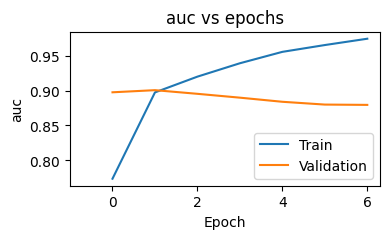

80/80 [==============================] - 0s 884us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5435 - auc: 0.7615 - val_loss: 0.3761 - val_auc: 0.9070
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3893 - auc: 0.8916 - val_loss: 0.3584 - val_auc: 0.9098
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3269 - auc: 0.9254 - val_loss: 0.3603 - val_auc: 0.9099
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2847 - auc: 0.9425 - val_loss: 0.3967 - val_auc: 0.8972
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2414 - auc: 0.9576 - val_loss: 0.4323 - val_auc: 0.8998
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2244 - auc: 0.9641 - val_loss: 0.4615 - val_auc: 0.8936
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2043 - auc: 0.9703 -

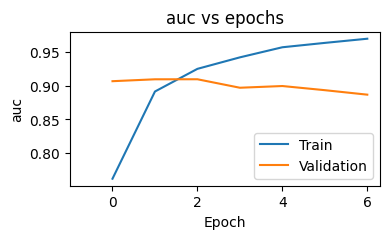

80/80 [==============================] - 0s 934us/step
Finished in 0
Training:  DL_4layers / bow_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5672 - auc: 0.7285 - val_loss: 0.3888 - val_auc: 0.8992
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.4056 - auc: 0.8841 - val_loss: 0.3557 - val_auc: 0.9118
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3436 - auc: 0.9176 - val_loss: 0.3621 - val_auc: 0.9118
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2889 - auc: 0.9408 - val_loss: 0.4050 - val_auc: 0.8979
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2460 - auc: 0.9557 - val_loss: 0.4597 - val_auc: 0.8894
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2083 - auc: 0.9681 - val_loss: 0.5160 - val_auc: 0.8761
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1860 - auc: 0.9743 -

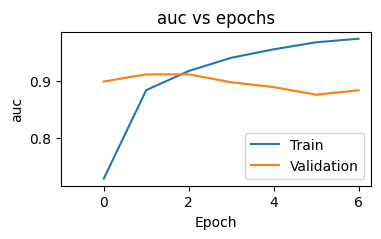

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.4977 - auc: 0.8007 - val_loss: 0.3660 - val_auc: 0.9043
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3520 - auc: 0.9098 - val_loss: 0.3591 - val_auc: 0.9042
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3033 - auc: 0.9325 - val_loss: 0.3798 - val_auc: 0.8978
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2616 - auc: 0.9502 - val_loss: 0.4116 - val_auc: 0.8891
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2215 - auc: 0.9637 - val_loss: 0.4326 - val_auc: 0.8886
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1916 - auc: 0.9721 - val_loss: 0.4587 - val_auc: 0.8846
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1664 - auc: 0.9792 -

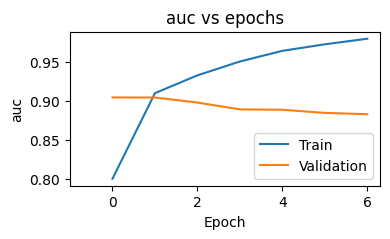

80/80 [==============================] - 0s 871us/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5033 - auc: 0.7923 - val_loss: 0.3619 - val_auc: 0.9078
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3532 - auc: 0.9089 - val_loss: 0.3643 - val_auc: 0.9055
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2979 - auc: 0.9355 - val_loss: 0.3942 - val_auc: 0.8973
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2566 - auc: 0.9513 - val_loss: 0.4078 - val_auc: 0.8922
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2156 - auc: 0.9654 - val_loss: 0.4616 - val_auc: 0.8816
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1814 - auc: 0.9750 - val_loss: 0.4712 - val_auc: 0.8818


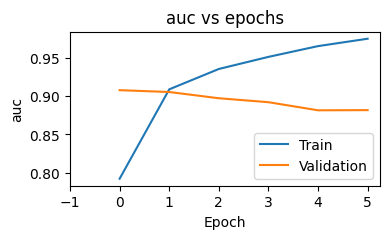

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.5003 - auc: 0.7993 - val_loss: 0.3658 - val_auc: 0.9054
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3441 - auc: 0.9137 - val_loss: 0.3657 - val_auc: 0.9022
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2992 - auc: 0.9351 - val_loss: 0.3790 - val_auc: 0.8974
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2533 - auc: 0.9532 - val_loss: 0.4084 - val_auc: 0.8897
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2205 - auc: 0.9633 - val_loss: 0.4494 - val_auc: 0.8844
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1904 - auc: 0.9720 - val_loss: 0.4743 - val_auc: 0.8781
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1677 - auc: 0.9783

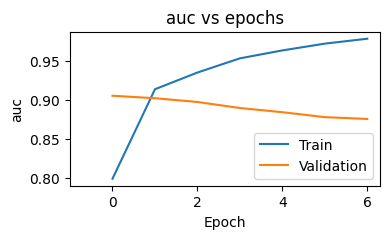

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer1500
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.4994 - auc: 0.7934 - val_loss: 0.3695 - val_auc: 0.8994
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3522 - auc: 0.9099 - val_loss: 0.3671 - val_auc: 0.8996
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2954 - auc: 0.9366 - val_loss: 0.3955 - val_auc: 0.8940
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2505 - auc: 0.9536 - val_loss: 0.4164 - val_auc: 0.8839
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2089 - auc: 0.9680 - val_loss: 0.4655 - val_auc: 0.8777
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1733 - auc: 0.9772 - val_loss: 0.5263 - val_auc: 0.8722
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1495 - auc: 0.9830

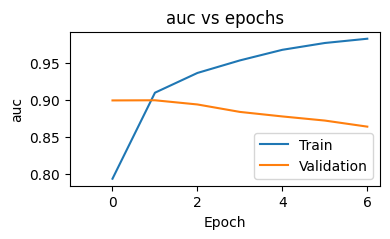

80/80 [==============================] - 0s 959us/step
Finished in 0
Training:  DL_3layers / bow_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5281 - auc: 0.7752 - val_loss: 0.3757 - val_auc: 0.9049
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3753 - auc: 0.8997 - val_loss: 0.3559 - val_auc: 0.9103
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3060 - auc: 0.9341 - val_loss: 0.3825 - val_auc: 0.9034
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2599 - auc: 0.9515 - val_loss: 0.4022 - val_auc: 0.8968
Epoch 5/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2295 - auc: 0.9638 - val_loss: 0.4263 - val_auc: 0.8949
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2028 - auc: 0.9693 - val_loss: 0.4522 - val_auc: 0.8946
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1791 - auc: 0.9756 -

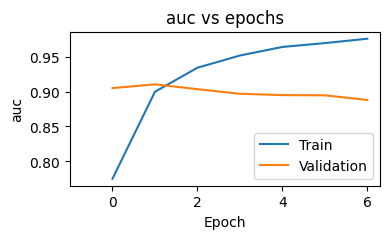

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_4layers / bow_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5520 - auc: 0.7515 - val_loss: 0.3852 - val_auc: 0.8973
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3882 - auc: 0.8963 - val_loss: 0.3626 - val_auc: 0.9079
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3252 - auc: 0.9279 - val_loss: 0.3830 - val_auc: 0.9045
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2697 - auc: 0.9481 - val_loss: 0.3885 - val_auc: 0.8978
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2228 - auc: 0.9651 - val_loss: 0.4272 - val_auc: 0.8960
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1935 - auc: 0.9735 - val_loss: 0.4671 - val_auc: 0.8881
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1757 - auc: 0.9791 - v

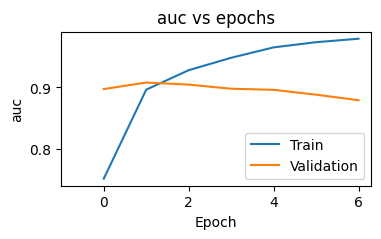

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.4945 - auc: 0.8029 - val_loss: 0.3698 - val_auc: 0.9046
Epoch 2/10
285/285 [==============================] - 1s 2ms/step - loss: 0.3373 - auc: 0.9171 - val_loss: 0.3667 - val_auc: 0.9016
Epoch 3/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2824 - auc: 0.9413 - val_loss: 0.3801 - val_auc: 0.8993
Epoch 4/10
285/285 [==============================] - 1s 2ms/step - loss: 0.2396 - auc: 0.9569 - val_loss: 0.4159 - val_auc: 0.8921
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2045 - auc: 0.9682 - val_loss: 0.4521 - val_auc: 0.8824
Epoch 6/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1759 - auc: 0.9761 - val_loss: 0.4763 - val_auc: 0.8801
Epoch 7/10
285/285 [==============================] - 1s 2ms/step - loss: 0.1563 - auc: 0.9808 -

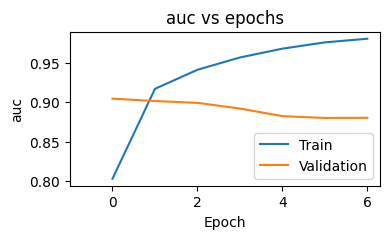

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_4layers / tfidf_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 4ms/step - loss: 0.5015 - auc: 0.7968 - val_loss: 0.3716 - val_auc: 0.9010
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3399 - auc: 0.9163 - val_loss: 0.3647 - val_auc: 0.9029
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2811 - auc: 0.9422 - val_loss: 0.3944 - val_auc: 0.8979
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2244 - auc: 0.9620 - val_loss: 0.4399 - val_auc: 0.8880
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1843 - auc: 0.9740 - val_loss: 0.4820 - val_auc: 0.8813
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1542 - auc: 0.9806 - val_loss: 0.5301 - val_auc: 0.8778
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1296 - auc: 0.9864 -

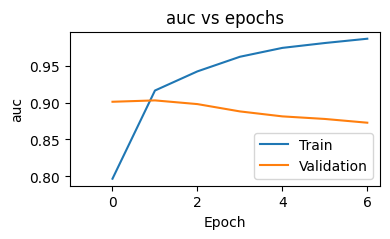

80/80 [==============================] - 0s 1ms/step
Finished in 0
Training:  DL_3layers / tfidf2g_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 3ms/step - loss: 0.4941 - auc: 0.8073 - val_loss: 0.3633 - val_auc: 0.9048
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3361 - auc: 0.9173 - val_loss: 0.3622 - val_auc: 0.9044
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2802 - auc: 0.9427 - val_loss: 0.3923 - val_auc: 0.8947
Epoch 4/10
285/285 [==============================] - 1s 4ms/step - loss: 0.2388 - auc: 0.9581 - val_loss: 0.4243 - val_auc: 0.8876
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1972 - auc: 0.9707 - val_loss: 0.4775 - val_auc: 0.8778
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1647 - auc: 0.9796 - val_loss: 0.5158 - val_auc: 0.8734
Epoch 7/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1383 - auc: 0.9857

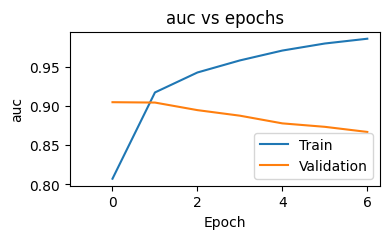

80/80 [==============================] - 0s 2ms/step
Finished in 0
Training:  DL_4layers / tfidf2g_vectorizer2000
Epoch 1/10
285/285 [==============================] - 2s 5ms/step - loss: 0.4988 - auc: 0.7979 - val_loss: 0.3614 - val_auc: 0.9048
Epoch 2/10
285/285 [==============================] - 1s 3ms/step - loss: 0.3427 - auc: 0.9149 - val_loss: 0.3624 - val_auc: 0.9043
Epoch 3/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2730 - auc: 0.9462 - val_loss: 0.4073 - val_auc: 0.8940
Epoch 4/10
285/285 [==============================] - 1s 3ms/step - loss: 0.2266 - auc: 0.9612 - val_loss: 0.4534 - val_auc: 0.8854
Epoch 5/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1805 - auc: 0.9754 - val_loss: 0.5058 - val_auc: 0.8760
Epoch 6/10
285/285 [==============================] - 1s 3ms/step - loss: 0.1479 - auc: 0.9825 - val_loss: 0.5453 - val_auc: 0.8732


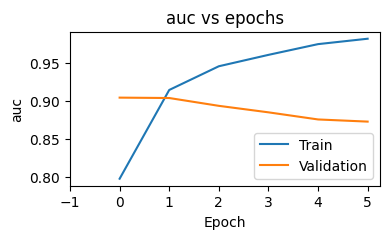

80/80 [==============================] - 0s 1ms/step
Finished in 0
CPU times: total: 25min 20s
Wall time: 3min 29s


In [161]:
%%time
vectorizer_list = [bow_vectorizer, tfidf_vectorizer, tfidf2g_vectorizer]
n_features = [500,800, 1000, 1500, 2000]

models = [
    ('DL_3layers',(128,64,32), (0.5,0.2,0.1)), # model name, neurons, dropout
    ('DL_4layers', (256,128,64,32), (0.5,0.5,0.2,0.1))
]


# loop through the range of n_feature
for n_feature in n_features:
    # loop through the vectorizer
    for vectorizer in vectorizer_list:
        X_train_vectorized, X_test_vectorized = vectorizer(X_train, X_test, n_feature)
        X_train_vectorized = np.array(X_train_vectorized)
        X_test_vectorized = np.array(X_test_vectorized)
        # loop through the baseline DL models
        for model_name, neurons, dropouts in models:
            print(f'Training:  {model_name} / {vectorizer.__name__+str(n_feature)}')
            start = time.time()
            dl_model = make_DL_model(neurons, dropouts, input_dim = n_feature)
            history = dl_model.fit(X_train_vectorized, y_train, 
                                batch_size=32,
                                epochs=10,
                                callbacks=[callback],
                                verbose=1,
                                validation_split = 0.1)
            completion_time = round(time.time() - start,2)
            accuracy_vs_epochs(history)
            dl_performance(model_name, dl_model, vectorizer.__name__+str(n_feature), 
                           X_train_vectorized, X_test_vectorized, y_train, y_test)

In [162]:
df_metrics[summary2]

,model name,data,time,train_acc,test_acc,test_up_F1,test_down_F1
0,DL_3layers,bow_vectorizer500,0,0.86,0.83,0.87,0.72
1,DL_4layers,bow_vectorizer500,0,0.84,0.82,0.87,0.69
2,DL_3layers,tfidf_vectorizer500,0,0.85,0.82,0.87,0.71
3,DL_4layers,tfidf_vectorizer500,0,0.87,0.82,0.87,0.71
4,DL_3layers,tfidf2g_vectorizer500,0,0.85,0.82,0.87,0.72
5,DL_4layers,tfidf2g_vectorizer500,0,0.87,0.82,0.87,0.71
6,DL_3layers,bow_vectorizer800,0,0.86,0.83,0.88,0.73
7,DL_4layers,bow_vectorizer800,0,0.88,0.83,0.88,0.73
8,DL_3layers,tfidf_vectorizer800,0,0.87,0.83,0.88,0.73
9,DL_4layers,tfidf_vectorizer800,0,0.88,0.83,0.87,0.73


In [163]:
df_metrics_combined = pd.concat([df_metrics, df_metrics_nonDL]).reset_index()
df_metrics_combined['preprocessed'] = df_metrics_combined.data.str.split('_').apply(lambda x: x[0])
df_metrics_combined['feature_size'] = df_metrics_combined.data.str.split('_').apply(lambda x: x[-1][10:])

In [164]:
df_metrics_combined

,index,model name,data,time,train_down_Pre,train_down_Rec,train_down_F1,train_up_Pre,train_up_Rec,train_up_F1,train_acc,test_down_Pre,test_down_Rec,test_down_F1,test_up_Pre,test_up_Rec,test_up_F1,test_acc,preprocessed,feature_size
0,0,DL_3layers,bow_vectorizer500,0.00,0.84,0.71,0.77,0.87,0.93,0.90,0.86,0.77,0.67,0.72,0.85,0.90,0.87,0.83,bow,500
1,1,DL_4layers,bow_vectorizer500,0.00,0.83,0.66,0.73,0.85,0.93,0.89,0.84,0.78,0.62,0.69,0.83,0.92,0.87,0.82,bow,500
2,2,DL_3layers,tfidf_vectorizer500,0.00,0.83,0.71,0.76,0.86,0.93,0.89,0.85,0.77,0.66,0.71,0.84,0.90,0.87,0.82,tfidf,500
3,3,DL_4layers,tfidf_vectorizer500,0.00,0.85,0.75,0.79,0.88,0.93,0.91,0.87,0.75,0.67,0.71,0.84,0.89,0.87,0.82,tfidf,500
4,4,DL_3layers,tfidf2g_vectorizer500,0.00,0.82,0.71,0.76,0.86,0.92,0.89,0.85,0.77,0.67,0.72,0.85,0.90,0.87,0.82,tfidf2g,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,55,XGB_classifier,tfidf_vectorizer2000,8.99,0.95,0.73,0.83,0.88,0.98,0.93,0.90,0.82,0.61,0.69,0.83,0.93,0.88,0.82,tfidf,2000
86,56,NB_classifier,tfidf2g_vectorizer2000,0.12,0.87,0.64,0.74,0.84,0.95,0.89,0.85,0.84,0.59,0.69,0.82,0.94,0.88,0.82,tfidf2g,2000
87,57,LG_classifier,tfidf2g_vectorizer2000,0.83,0.88,0.71,0.78,0.87,0.95,0.91,0.87,0.83,0.65,0.73,0.84,0.93,0.89,0.84,tfidf2g,2000
88,58,RF_classifier,tfidf2g_vectorizer2000,25.77,0.99,0.94,0.96,0.97,0.99,0.98,0.98,0.79,0.63,0.70,0.83,0.92,0.87,0.82,tfidf2g,2000


### Compare DL models to baseline classification models

#### Accuracy on test set, by model

<Axes: xlabel='model name', ylabel='test_acc'>

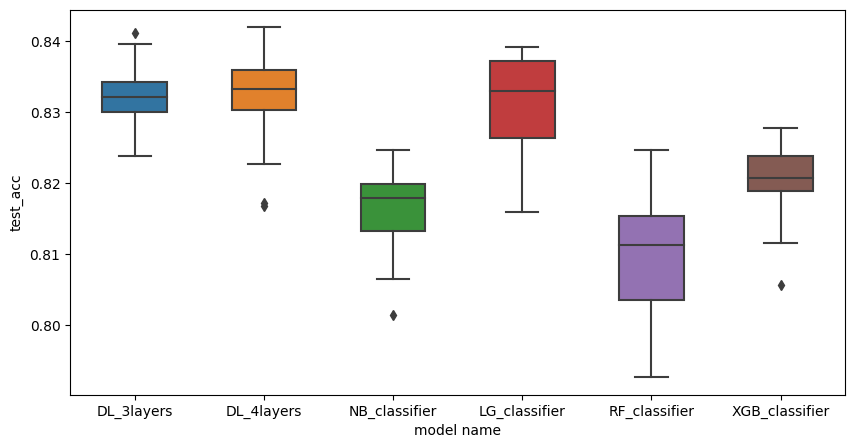

In [165]:
plt.figure(figsize = (10,5))
sns.boxplot(data=df_metrics_combined, x='model name', y='test_acc', width=0.5)

#### F1 score for negative on test set, by model

<Axes: xlabel='model name', ylabel='test_down_F1'>

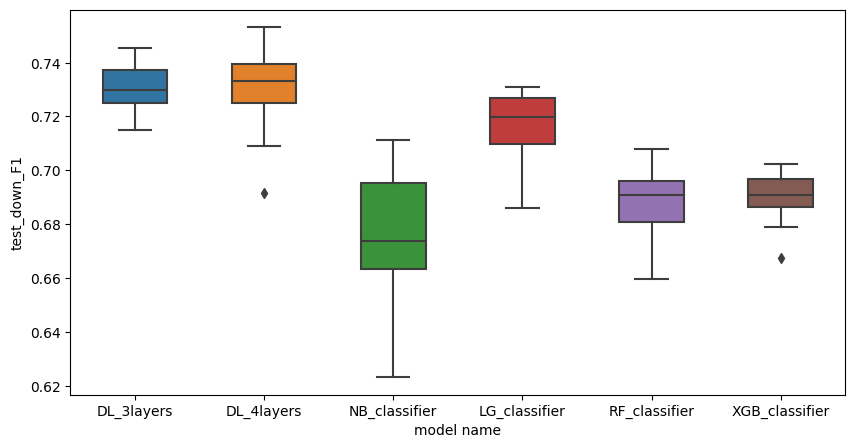

In [166]:
plt.figure(figsize = (10,5))
sns.boxplot(data=df_metrics_combined, x='model name', y='test_down_F1', width=0.5)

- While accuracy of DL on test set is not significanty higher than baseline models, F1 score is a lot better.

#### F1 score for negative on test set, by model AND preprocess

<Axes: xlabel='model name', ylabel='test_down_F1'>

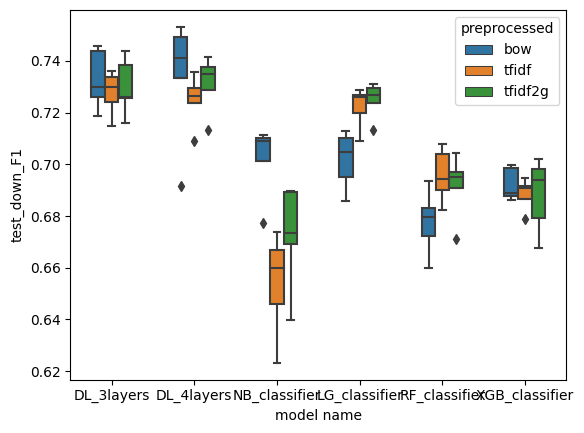

In [167]:
sns.boxplot(data=df_metrics_combined, x='model name', y='test_down_F1', hue='preprocessed', width=0.5)

#### F1 score for negative on test set, by model AND feature size

<Axes: xlabel='model name', ylabel='test_down_F1'>

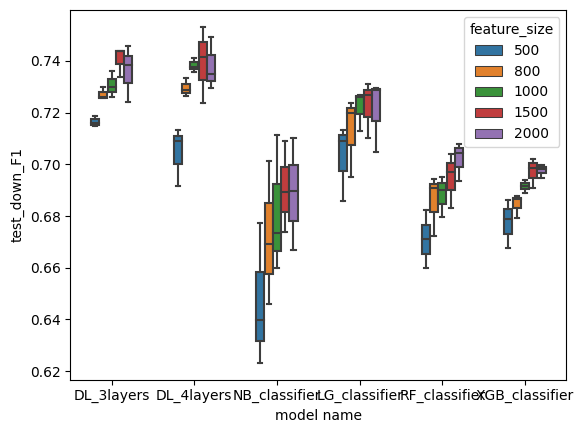

In [168]:
sns.boxplot(data=df_metrics_combined, x='model name', y='test_down_F1', hue='feature_size', width=0.5)

### Time of completion

#### Time of completion by model

<Axes: xlabel='model name', ylabel='time'>

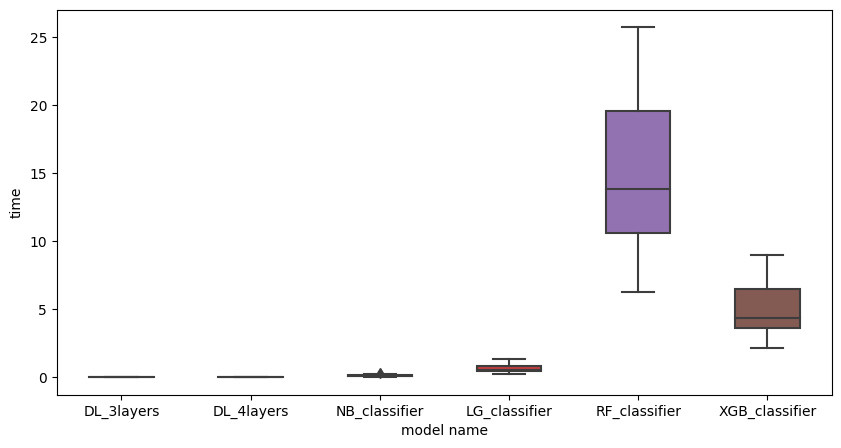

In [169]:
plt.figure(figsize = (10,5))
sns.boxplot(data=df_metrics_combined, x='model name', y='time', width=0.5)

#### Time of completion by model AND preprocess

<Axes: xlabel='model name', ylabel='time'>

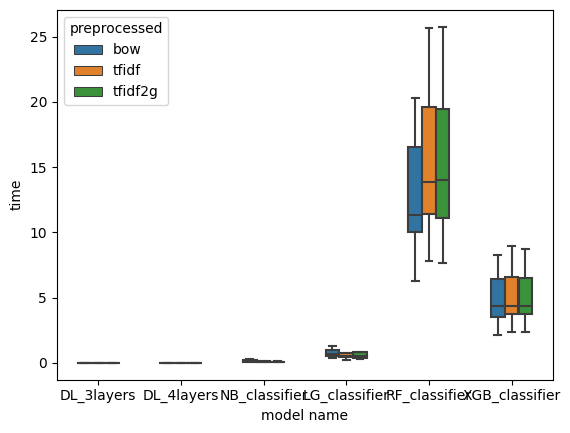

In [170]:
sns.boxplot(data=df_metrics_combined, x='model name', y='time', hue='preprocessed', width=0.5)

#### Time of completion by model AND feature size

<Axes: xlabel='model name', ylabel='time'>

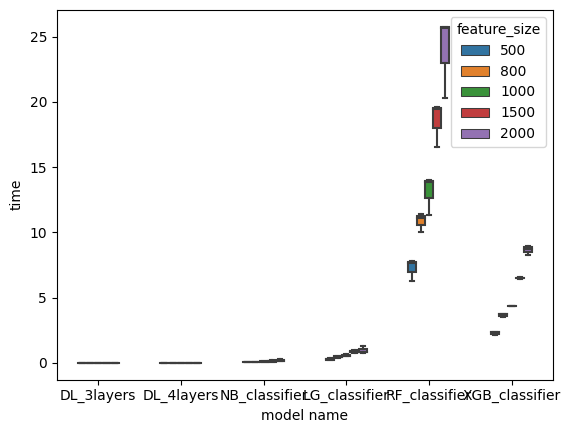

In [171]:
sns.boxplot(data=df_metrics_combined, x='model name', y='time', hue='feature_size', width=0.5)

# 7. Conclusion